## おせんべい or クッキー分類プロジェクト
ランダムフォレストでせんべいかクッキーか分類するモデルを作る

### 準備
ローカルからおせんべいフォルダとクッキーフォルダをアップロードする  
ランダムな8割で学習、残り2割でテストとする

### 特徴量
- 色特徴量
- HOG
- LBP

### 混同行列作成
評価は混同行列だけ用意する

### 発展編
興味があればSAMでおせんべいかクッキーの箇所だけに絞って、やってみてください。  
またいろいろな特徴量を試してみてください（エッジ処理したのちに〜を計算など）。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install japanize_matplotlib

In [3]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
# データセットへのパスを指定
image_dir = "/content/drive/MyDrive/案件/学習動画/udemy/画像解析"

# 画像データとラベルを格納するリスト
images = []
labels = []

# おせんべい画像の読み込みと前処理
for filename in os.listdir(os.path.join(image_dir, "おせんべい")):
    if filename.endswith((".jpg", ".jpeg", ".png")):  # 画像ファイルの拡張子に合わせて変更
        img_path = os.path.join(image_dir, "おせんべい", filename)
        try:
            img = Image.open(img_path)
            img = img.resize((64, 64))  # 画像サイズを統一
            img_array = np.array(img)
            images.append(img_array)
            labels.append(0)  # おせんべいはラベル0
        except Exception as e:
            print(f"Error processing {img_path}: {e}")


# クッキー画像の読み込みと前処理 (おせんべいと同じように処理)
for filename in os.listdir(os.path.join(image_dir, "クッキー")):
    if filename.endswith((".jpg", ".jpeg", ".png")):
        img_path = os.path.join(image_dir, "クッキー", filename)
        try:
            img = Image.open(img_path)
            img = img.resize((64, 64))
            img_array = np.array(img)
            images.append(img_array)
            labels.append(1)  # クッキーはラベル1
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# データをNumPy配列に変換
images = np.array(images)
labels = np.array(labels)

# データの形状を確認
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Images shape: (109, 64, 64, 3)
Labels shape: (109,)


In [5]:
# データを訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
from skimage.feature import hog, local_binary_pattern
import numpy as np

def extract_features(image):
  # RGBの平均と分散を計算
  r_mean = np.mean(image[:, :, 0])
  g_mean = np.mean(image[:, :, 1])
  b_mean = np.mean(image[:, :, 2])
  r_var = np.var(image[:, :, 0])
  g_var = np.var(image[:, :, 1])
  b_var = np.var(image[:, :, 2])

  # HOG特徴量を計算
  fd, hog_image = hog(image, orientations=9, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=2)
  # fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
  #                   cells_per_block=(1, 1), visualize=True, channel_axis=2)
  # print("fd shape: ", fd.shape)

  # LBP特徴量を計算
  radius = 3
  n_points = 8 * radius
  lbp = local_binary_pattern(image[:, :, 0], n_points, radius, method='uniform') # Gray画像として処理
  lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
  lbp_hist = lbp_hist.astype("float")
  lbp_hist /= (lbp_hist.sum() + 1e-7)
  # print("lbp shape: ", lbp_hist.shape)

  # 特徴量を結合
  features = np.concatenate(([r_mean, g_mean, b_mean, r_var, g_var, b_var], fd, lbp_hist))
  return features


手順 | 計算 | 結果  
セル数 | 64 px ÷ 16 px = 4  → 4 × 4 = 16 セル | 16  
ブロック数 | ブロックは 1 セル単位なのでそのまま 16 ブロック | 16  
1ブロック当たり次元 | 方向ビンが 8個、セルは1×1 | 8  
全体の次元 | 16 ブロック × 8 = 128 | 128  

In [7]:
y_test

array([1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0])

In [8]:
import pandas as pd

# 特徴量抽出（リストでまとめる）
X_train_features_list = [extract_features(img) for img in X_train]
X_test_features_list = [extract_features(img) for img in X_test]

# カラム名の作成
feature_names = []

# RGBの統計量
feature_names += ['r_mean', 'g_mean', 'b_mean', 'r_var', 'g_var', 'b_var']

# HOG特徴量（fdの次元数を確認して）
hog_dim = len(X_train_features_list[0]) - 6 - 26  # 全体 - RGB6 - LBP26
feature_names += [f'hog_{i}' for i in range(hog_dim)]

# LBP特徴量
feature_names += [f'lbp_{i}' for i in range(26)]  # LBPは26ビン

# DataFrameに変換
X_train_df = pd.DataFrame(X_train_features_list, columns=feature_names)
X_test_df = pd.DataFrame(X_test_features_list, columns=feature_names)

# 確認
X_train_df.head()

,r_mean,g_mean,b_mean,r_var,g_var,b_var,hog_0,hog_1,hog_2,hog_3,...,lbp_16,lbp_17,lbp_18,lbp_19,lbp_20,lbp_21,lbp_22,lbp_23,lbp_24,lbp_25
0,174.004395,170.329102,159.402588,698.774395,1130.197356,2892.190218,0.231522,0.307045,0.544384,0.544384,...,0.028320,0.017822,0.011230,0.006836,0.005615,0.007080,0.006836,0.010986,0.026123,0.203613
1,172.749512,168.759033,156.388428,934.808349,1173.920695,2223.265384,0.435000,0.435000,0.435000,0.249565,...,0.021484,0.019531,0.013428,0.011230,0.010498,0.010254,0.018799,0.009521,0.017334,0.278809
2,173.915039,171.613770,161.255127,1230.544539,1444.930904,2290.074315,0.318770,0.109172,0.279499,0.483312,...,0.022949,0.016113,0.014404,0.012939,0.014404,0.016113,0.016357,0.009521,0.015869,0.270508
3,177.185791,172.315674,157.539307,1271.464749,1537.003133,2601.666912,0.386606,0.386606,0.386606,0.333810,...,0.026367,0.022949,0.016113,0.016846,0.013428,0.016602,0.013184,0.010742,0.018066,0.292725
4,176.517578,174.339355,164.892578,1159.175472,1307.733471,2003.321957,0.376335,0.101624,0.343076,0.463469,...,0.022217,0.017090,0.009766,0.011963,0.006348,0.010742,0.018311,0.010742,0.016846,0.278809


In [9]:
# 標準化（スケーリング）
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

In [10]:
# ランダムフォレスト分類器のインスタンスを作成
rf_classifier = RandomForestClassifier(random_state=42)

# モデルを訓練データで学習
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

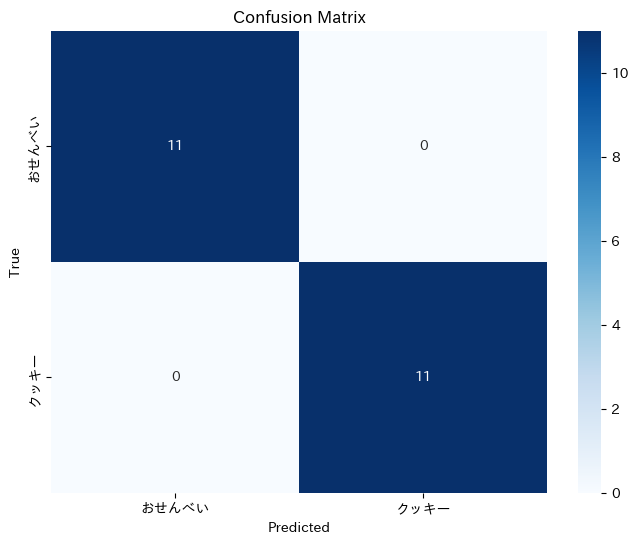

In [11]:
# テストデータで予測
y_pred = rf_classifier.predict(X_test_scaled)

# 混同行列を作成
cm = confusion_matrix(y_test, y_pred)

# 混同行列をヒートマップで表示
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["おせんべい", "クッキー"], yticklabels=["おせんべい", "クッキー"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [12]:
# テストデータで予測確率を取得
y_pred_proba = rf_classifier.predict_proba(X_test_scaled)

# 予測結果と確率を表示
for i in range(len(y_test)):
    print(f"Image {i+1}:")
    print(f"  True label: {y_test[i]} ({'おせんべい' if y_test[i] == 0 else 'クッキー'})")
    print(f"  Predicted label: {y_pred[i]} ({'おせんべい' if y_pred[i] == 0 else 'クッキー'})")
    print(f"  Probabilities: おせんべい={y_pred_proba[i][0]:.2f}, クッキー={y_pred_proba[i][1]:.2f}")
    print("-" * 20)

Image 1:
  True label: 1 (クッキー)
  Predicted label: 1 (クッキー)
  Probabilities: おせんべい=0.08, クッキー=0.92
--------------------
Image 2:
  True label: 0 (おせんべい)
  Predicted label: 0 (おせんべい)
  Probabilities: おせんべい=0.94, クッキー=0.06
--------------------
Image 3:
  True label: 0 (おせんべい)
  Predicted label: 0 (おせんべい)
  Probabilities: おせんべい=0.96, クッキー=0.04
--------------------
Image 4:
  True label: 1 (クッキー)
  Predicted label: 1 (クッキー)
  Probabilities: おせんべい=0.04, クッキー=0.96
--------------------
Image 5:
  True label: 1 (クッキー)
  Predicted label: 1 (クッキー)
  Probabilities: おせんべい=0.07, クッキー=0.93
--------------------
Image 6:
  True label: 1 (クッキー)
  Predicted label: 1 (クッキー)
  Probabilities: おせんべい=0.01, クッキー=0.99
--------------------
Image 7:
  True label: 0 (おせんべい)
  Predicted label: 0 (おせんべい)
  Probabilities: おせんべい=0.98, クッキー=0.02
--------------------
Image 8:
  True label: 0 (おせんべい)
  Predicted label: 0 (おせんべい)
  Probabilities: おせんべい=0.97, クッキー=0.03
--------------------
Image 9:
  True label: 1 (クッキー)


In [13]:
# 特徴量重要度を取得
importances = rf_classifier.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,  # カラム名
    'Importance': importances  # 重要度
})

# 重要度順にソート
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 表示
feature_importance_df.head(20)

,Feature,Importance
3,r_var,0.063466
16,hog_10,0.059112
127,hog_121,0.056795
21,hog_15,0.053963
145,lbp_11,0.052439
156,lbp_22,0.049402
136,lbp_2,0.042196
29,hog_23,0.040019
35,hog_29,0.038126
37,hog_31,0.034789
